# Algoritmos de detección de comunidades


A continuación, se detallan algunos algoritmos de detección de comunidades. Es necesario prestar atención a las características de las funciones que implementan los algoritmos, ya que el output de las mismas suele variar.

# Instalamos e importamos librerías

In [4]:
!pip install python-louvain # Instalo un paquete que tiene Louvain y modularidad
!pip install python-igraph # Voy a usar igraph para infomap (tiene un montón de algoritmos de comunidades incluido)
!apt-get install libcairo2-dev libjpeg-dev libgif-dev # Para graficar Igraph (acá dendrogramas)
!pip install pycairo # Igraph usa Cairo para graficar

     |████████████████████████████████| 3.2MB 2.8MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libgif-dev libpixman-1-dev
  libxcb-shm0-dev
0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.
Need to get 951 kB of archives.
After this operation, 4,084 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-s

In [0]:
import networkx as nx # Para redes en general
import community as community_louvain # Importo el paquete que instalé en la línea de arriba
import igraph as ig # Importo igraph
import matplotlib.pylab as plt # Para graficar networkx y demases
import matplotlib.cm as cm # para mapas de colores
import numpy as np
from sklearn.metrics import normalized_mutual_info_score as mis # Función para calcular información mutua
import cairo # Importo Cairo
# Esto es para que funcione Cairo
from google.colab import files
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

# Cargamos las redes directamente de la página de la materia

In [0]:
# Primero, uso de los códigos subidos al cuaderno colaborativo para conseguir los datos del ejercicio
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
url = "http://materias.df.uba.ar/scytda2020c1/files/2020/04/TC04_ComunidadesData.zip"
with urlopen(url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
       archivos = zfile.namelist()
       for archivo in archivos:
           if archivo.endswith('.txt') or archivo.endswith('.gml') or archivo.endswith('.csv'):
               zfile.extract(archivo, '/content')


# Ejercicio 1

### Inciso (a)

la partición en comunidades de esta red utilizando la metodología Louvain, infomap,
fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

In [0]:
#cargamos la red de delfines
Red_delfines = nx.read_gml('/content/dolphins.gml')
posiciones = nx.kamada_kawai_layout(Red_delfines)

#definimos la red en Igraph desde la red en Networkx
Red_delfines_igraph = ig.Graph.TupleList(Red_delfines.edges(), directed=False)



In [0]:
# función que toma la Red de igraph y la partición calculada con Igraph, y la devuelve como diccionario
def convertir_particion_igraph_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def convertir_dict_a_lista(dict):
  categoria = set(dict.values())
  particiones = []
  for n in categoria:
    cluster = [k for k in dict.keys() if dict[k] == n]
    particiones.append(cluster)
  return particiones_louvline

#devuelve una lista de n colores hex
import random
def colores_hex(n):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(n)]
    return color


In [0]:
#calculamos las paticiones con los distintos métodos
particiones = {}

#particiones con Edge Betweenness
dendograma_edge_betweenness = Red_delfines_igraph.community_edge_betweenness(directed=False, weights=None)
particiones_edge_betweenness = dendograma_edge_betweenness.as_clustering()
dict_particiones_edge_betweenness = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_edge_betweenness)
particiones['Edge Betweenness'] = dict_particiones_edge_betweenness

#particiones con Fast Greedy
dendograma_fast_greedy = Red_delfines_igraph.community_fastgreedy(weights=None)
particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_fast_greedy)
particiones['Fast Greedy'] = dict_particiones_fast_greedy

#particiones con Louvline
dict_particiones_louvline = community_louvain.best_partition(Red_delfines)
particiones['Louvline'] = dict_particiones_louvline
#convertir_dict_a_lista(dict_particiones_louvline)

#particiones con infomap
particiones_infomap = Red_delfines_igraph.community_infomap()
dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_infomap)
particiones['Infomap'] = dict_particiones_infomap

No handles with labels found to put in legend.


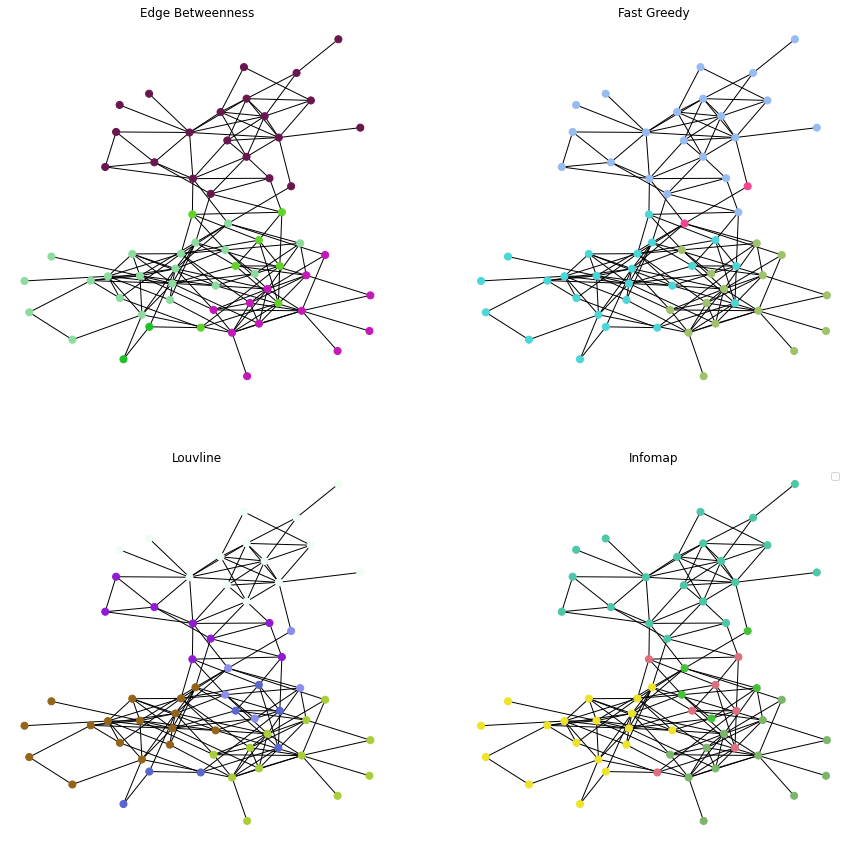

In [75]:
#dendograma_fast_greedy.optimal_count
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones):
  particion = particiones[metodo]
  colores = colores_hex(max(particion.values())+1) #funcion que devuelve n colores

  # le asigno un color a cada nodo
  node_color = []
  for node in Red_delfines.nodes():
    node_color.append(colores[particion[node]])

  nx.draw(Red_delfines, node_size= 50, ax = axs[i], node_color=node_color,pos=posiciones)
  axs[i].set_title(metodo)

plt.legend()
plt.show()
